# TP1 - Menceyra - Viaggio

### Pipeline: 
(1) Detección y descripción de Características visuales (features)

(2) Supresion no Máxima Adaptativa

(3) Asociación de características (Matching)

(4) Estimación de la homografía "manualmente"

(5) RANSAC para eliminación de outliers y estimación de homografías

(6) Cálculo de tamaño óptimo para imagen final

(7) Juntando y mezclando imágenes (Stitching and Blending)

In [11]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from pathlib import Path
from imgs_prep_vis import imread_rgb, resize_width, visualize_keypoints, visualize_comparison, draw_matches_gray
from utils import anms_select, match_descriptors, extract_matched_points

In [12]:
# Configuración
IMG_DIR = Path("img")
UDESA = ["udesa_0.jpg", "udesa_1.jpg", "udesa_2.jpg"]
CUADRO = ["cuadro_0.jpg", "cuadro_1.jpg", "cuadro_2.jpg"]
NUESTRA = ["nuestra_0.jpg", "nuestra_1.jpg", "nuestra_2.jpg"]
ANCHOR_IDX = 1  # Imagen ancla
RESIZE_W = 1000  # Ancho al que se redimensionan las imágenes

### UDESA
### (1)

In [13]:
# Carga y procesamiento de imágenes (UDESA)
imgs_udesa_rgb, imgs_udesa_gray = [], []
for u in UDESA:
    img_rgb = imread_rgb(IMG_DIR / u)
    img_rgb = resize_width(img_rgb, RESIZE_W)
    imgs_udesa_rgb.append(img_rgb)
    img_udesa_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    imgs_udesa_gray.append(img_udesa_gray)

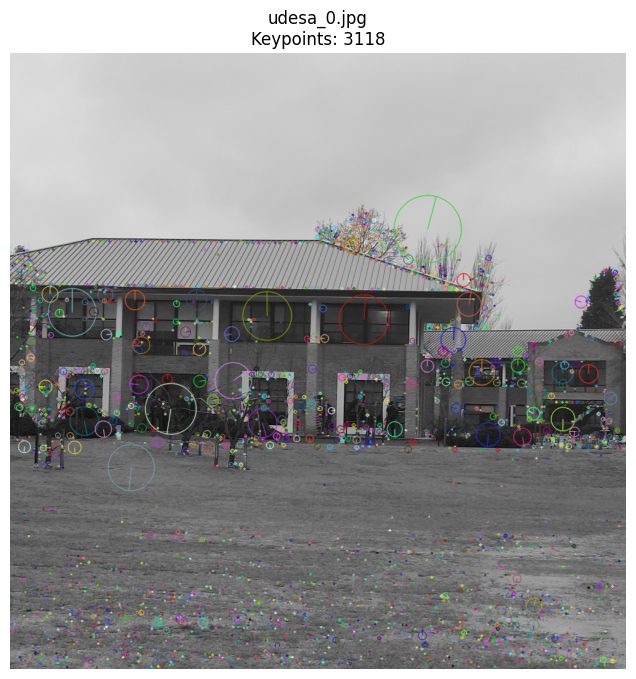

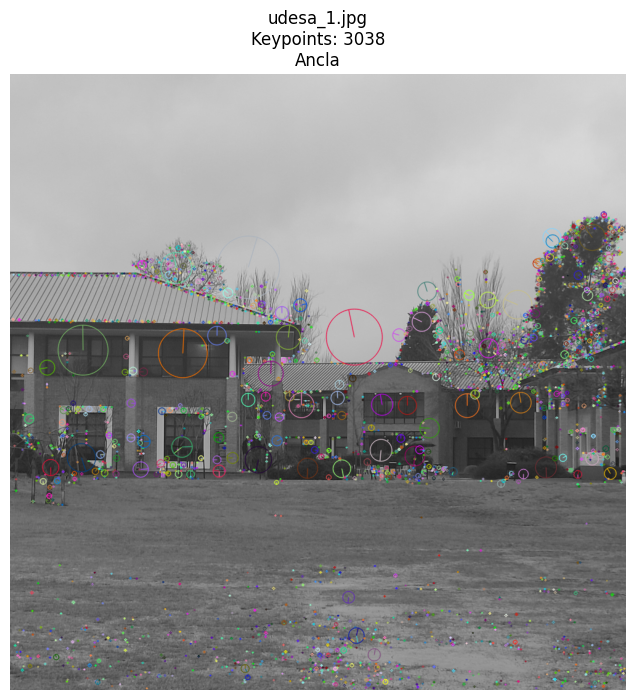

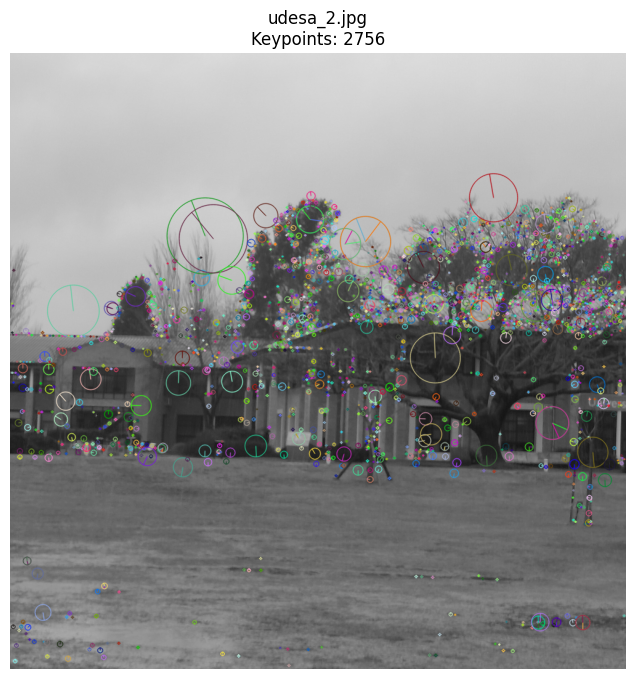

In [14]:
# SIFT y visualización de keypoints
sift = cv2.SIFT_create()

kps_udesa, descs_udesa = [], []
for idx, img_udesa_gray in enumerate(imgs_udesa_gray):
    kp, desc = sift.detectAndCompute(img_udesa_gray, None)
    kps_udesa.append(kp)
    descs_udesa.append(desc)

    # Visualización de keypoints
    visualize_keypoints(UDESA, idx, img_udesa_gray, kp, ANCHOR_IDX)

### (2)

udesa_0.jpg: 3118 keypoints -> 800 después de ANMS
udesa_1.jpg: 3038 keypoints -> 800 después de ANMS
udesa_2.jpg: 2756 keypoints -> 800 después de ANMS


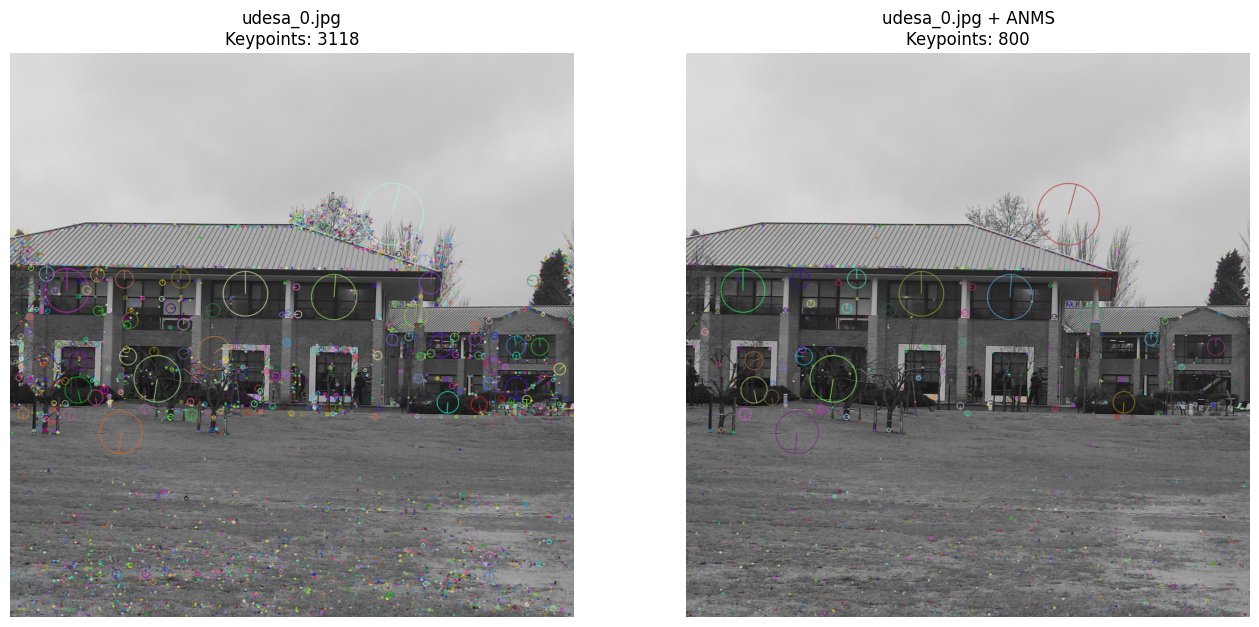

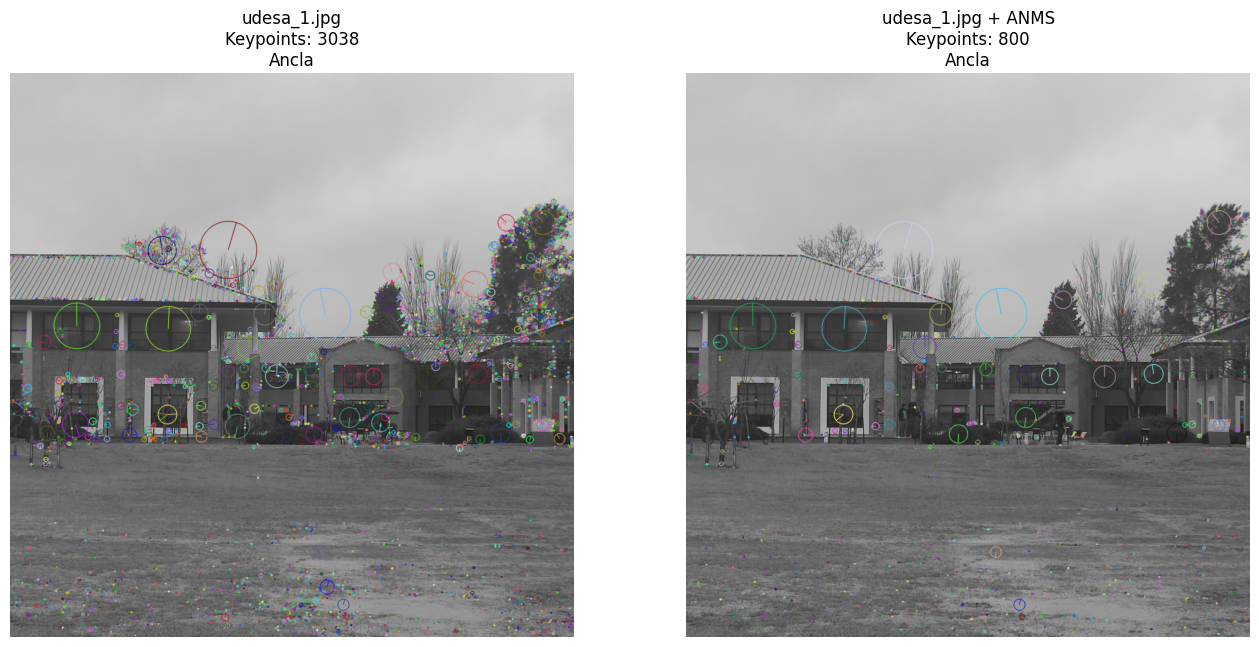

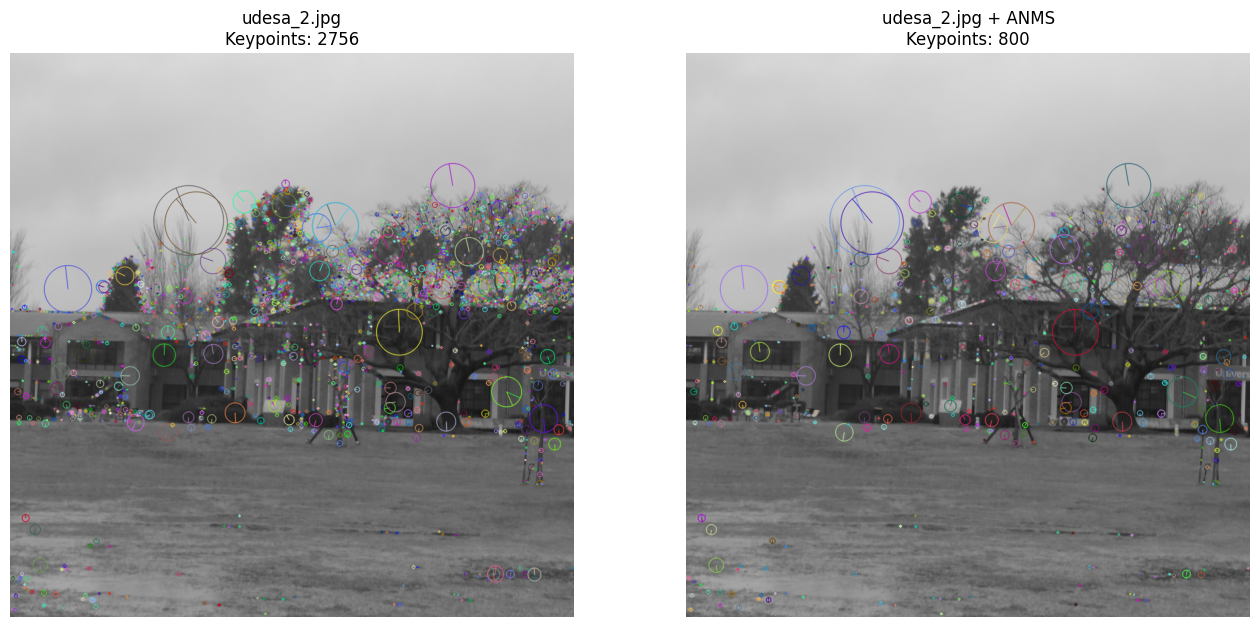

In [15]:
udesa_data = {
    "imgs": UDESA,
    "imgs_rgb": imgs_udesa_rgb,
    "imgs_gray": imgs_udesa_gray,
    "kps": kps_udesa,
    "descs": descs_udesa,
    "andor_idx": ANCHOR_IDX
}

# Adaptative Non-Maximal Suppression (ANMS)
kps_udesa_anms, descs_udesa_anms = [], []
for idx, (kps, descs) in enumerate(zip(kps_udesa, descs_udesa)):
    kps_anms, descs_anms = anms_select(kps, descs)
    kps_udesa_anms.append(kps_anms)
    descs_udesa_anms.append(descs_anms)
    print(f"{UDESA[idx]}: {len(kps)} keypoints -> {len(kps_anms)} después de ANMS")

# Visualización de keypoints antes vs. después de ANMS
for idx, (img_udesa_gray, kps, kps_anms) in enumerate(zip(imgs_udesa_gray, kps_udesa, kps_udesa_anms)):
    visualize_comparison(UDESA, idx, img_udesa_gray, kps, kps_anms, ANCHOR_IDX)

### (3)

=== Política A: SOLO Lowe ratio ===
udesa_1.jpg ↔ udesa_0.jpg: solo ratio=201


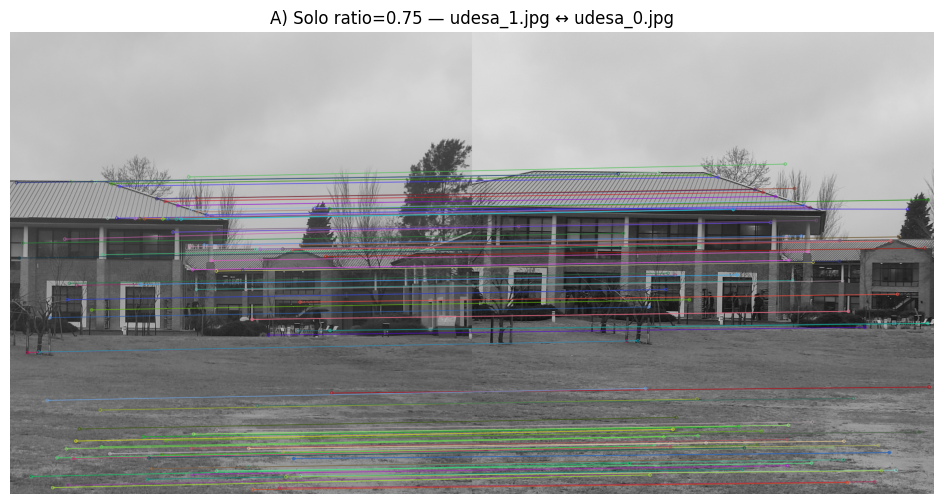

udesa_1.jpg ↔ udesa_0.jpg: ratio+cross=155 (vs solo ratio=201)


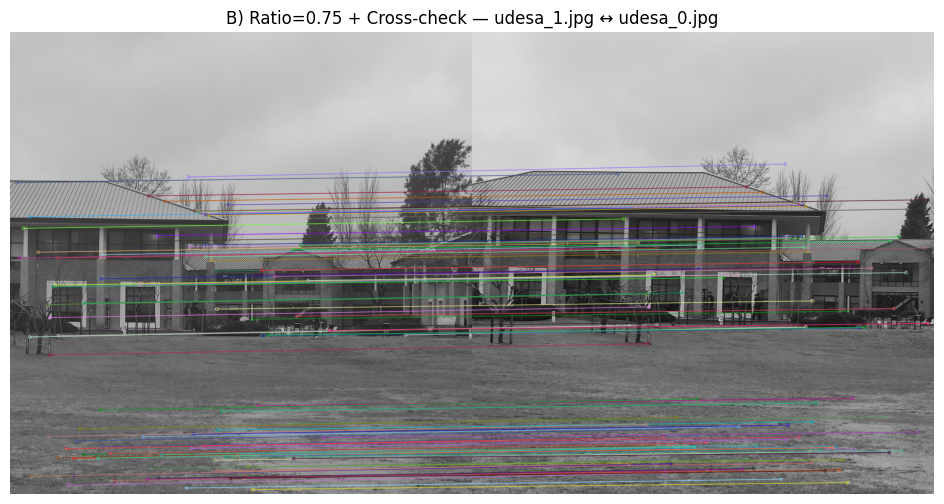

udesa_1.jpg ↔ udesa_2.jpg: solo ratio=52


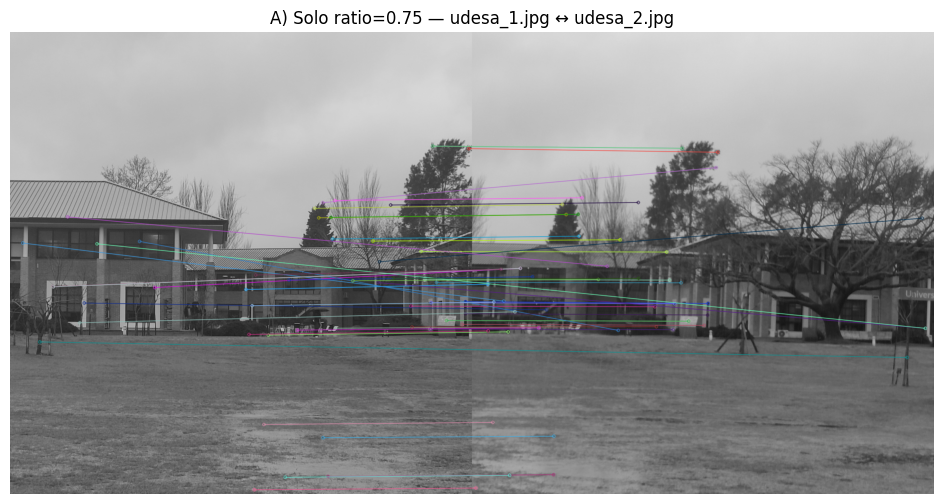

udesa_1.jpg ↔ udesa_2.jpg: ratio+cross=36 (vs solo ratio=52)


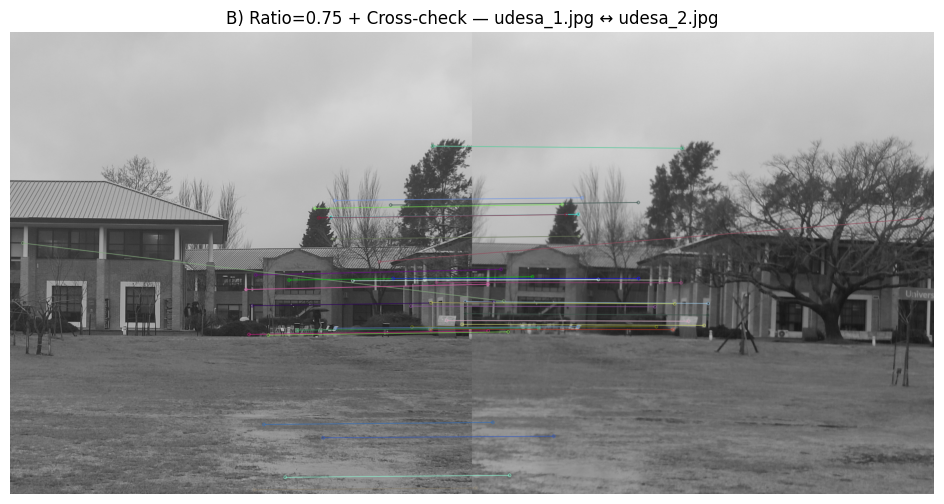

Listo: matches_udesa (solo ratio) y matches_udesa_alt (ratio+cross) listos para comparar.


In [ ]:
# Elegir descriptores (ANMS si existen; si no, crudos)
kps_list  = kps_udesa_anms  if 'kps_udesa_anms'  in globals() and len(kps_udesa_anms)==len(kps_udesa) else kps_udesa
desc_list = descs_udesa_anms if 'descs_udesa_anms' in globals() and len(descs_udesa_anms)==len(descs_udesa) else descs_udesa

# Pares contra la ancla 
pairs = []
if ANCHOR_IDX - 1 >= 0:
    pairs.append((ANCHOR_IDX, ANCHOR_IDX - 1))
if ANCHOR_IDX + 1 < len(kps_list):
    pairs.append((ANCHOR_IDX, ANCHOR_IDX + 1))

# Parámetros
METHOD   = "bf"     
RATIO    = 0.75
USE_LOWE = True

# Diccionarios de resultados
matches_udesa      = {}  # política principal (solo ratio)
matches_udesa_alt  = {}  # política alternativa (ratio + cross-check)

print("=== Política A: SOLO Lowe ratio ===")
for iA, iB in pairs:
    descA, descB = desc_list[iA], desc_list[iB]
    kpsA,  kpsB  = kps_list[iA],  kps_list[iB]

    if descA is None or descB is None or len(descA) == 0 or len(descB) == 0:
        print(f"Saltando {UDESA[iA]} ↔ {UDESA[iB]}: sin descriptores.")
        continue

    # --- Política A: solo Lowe ratio ---
    matches, dbg = match_descriptors(
        descA, descB,
        method=METHOD,
        use_lowe=USE_LOWE,
        ratio=RATIO,
        do_crosscheck=False
    )
    ptsA, ptsB = extract_matched_points(kpsA, kpsB, matches)
    key = f"{UDESA[iA]} ↔ {UDESA[iB]}"
    matches_udesa[key] = {"iA": iA, "iB": iB, "matches": matches,
                          "ptsA": ptsA, "ptsB": ptsB,
                          "kpsA": kpsA, "kpsB": kpsB, "debug": dbg}
    print(f"{key}: solo ratio={len(matches)}")
    draw_matches_gray(imgs_udesa_gray[iA], imgs_udesa_gray[iB],
                      kpsA, kpsB, matches, max_draw=100,
                      title=f"A) Solo ratio={RATIO} — {key}")

    # --- Política B: Lowe ratio + cross-check ---
    matches_xc, dbg_xc = match_descriptors(
        descA, descB,
        method=METHOD,
        use_lowe=USE_LOWE,
        ratio=RATIO,
        do_crosscheck=True
    )
    ptsA_xc, ptsB_xc = extract_matched_points(kpsA, kpsB, matches_xc)
    matches_udesa_alt[key] = {"iA": iA, "iB": iB, "matches": matches_xc,
                              "ptsA": ptsA_xc, "ptsB": ptsB_xc,
                              "kpsA": kpsA, "kpsB": kpsB, "debug": dbg_xc}
    print(f"{key}: ratio+cross={len(matches_xc)} (vs solo ratio={len(matches)})")
    draw_matches_gray(imgs_udesa_gray[iA], imgs_udesa_gray[iB],
                      kpsA, kpsB, matches_xc, max_draw=100,
                      title=f"B) Ratio={RATIO} + Cross-check — {key}")

# Guardar parámetros
matches_udesa_params = {"method": METHOD, "ratio": RATIO, "lowe": USE_LOWE}

print("Listo: matches_udesa (solo ratio) y matches_udesa_alt (ratio+cross) listos para comparar.")


### (4)

### CUADRO
### (1)

In [17]:
# Carga y procesamiento de imágenes (CUADRO)
imgs_cuadro_rgb, imgs_cuadro_gray = [], []
for c in CUADRO:
    img_rgb = imread_rgb(IMG_DIR / c)
    img_rgb = resize_width(img_rgb, RESIZE_W)
    imgs_cuadro_rgb.append(img_rgb)
    img_cuadro_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    imgs_cuadro_gray.append(img_cuadro_gray)

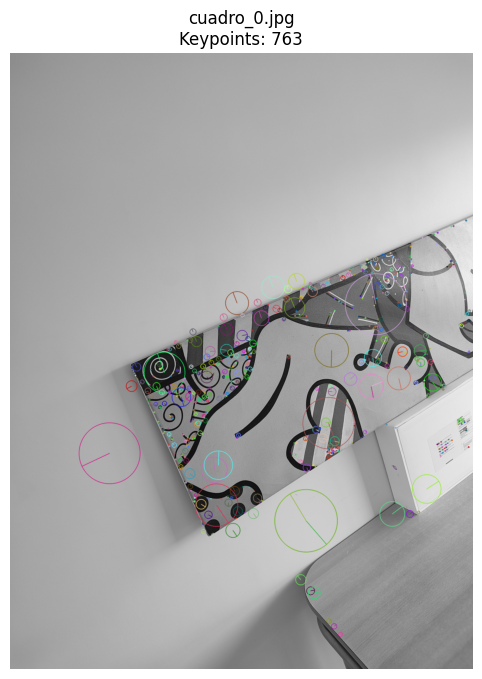

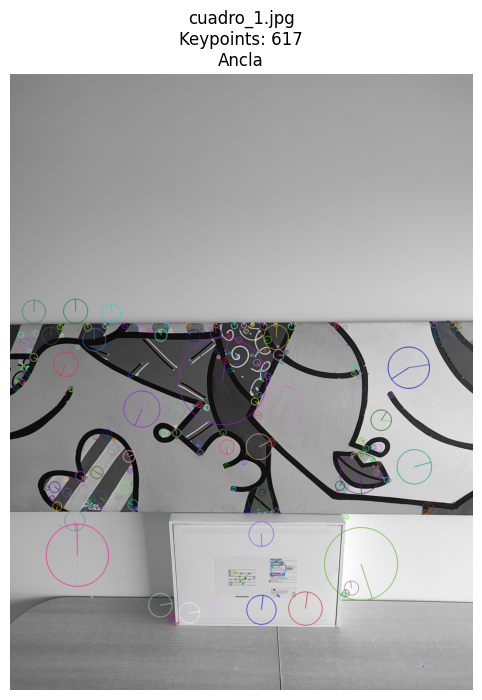

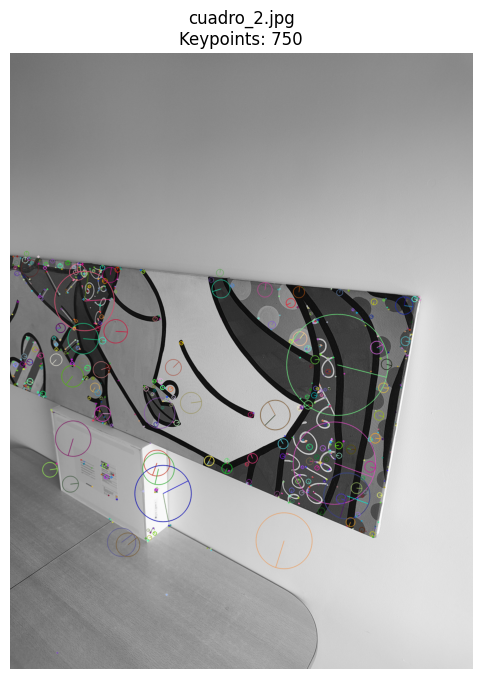

In [18]:
# SIFT y visualización de keypoints
kps_cuadro, descs_cuadro = [], []
for idx, img_cuadro_gray in enumerate(imgs_cuadro_gray):
    kp, desc = sift.detectAndCompute(img_cuadro_gray, None)
    kps_cuadro.append(kp)
    descs_cuadro.append(desc)

    # Visualización de keypoints
    visualize_keypoints(CUADRO, idx, img_cuadro_gray, kp, ANCHOR_IDX)

### (2)

cuadro_0.jpg: 763 keypoints -> 500 después de ANMS
cuadro_1.jpg: 617 keypoints -> 500 después de ANMS
cuadro_2.jpg: 750 keypoints -> 500 después de ANMS


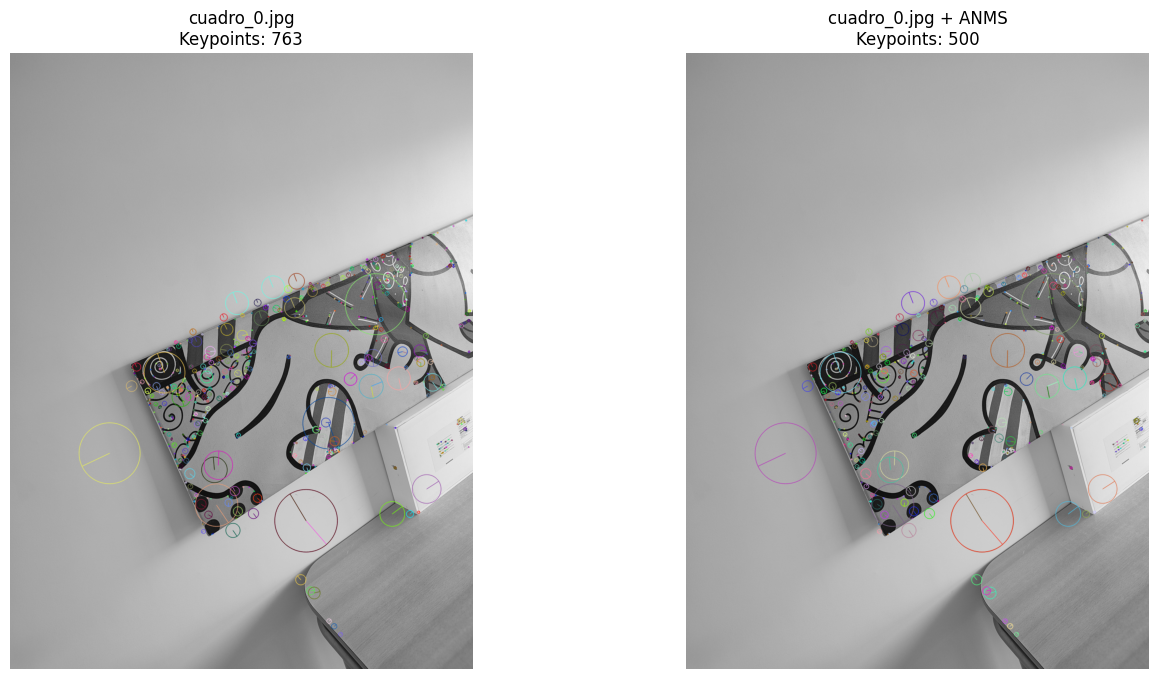

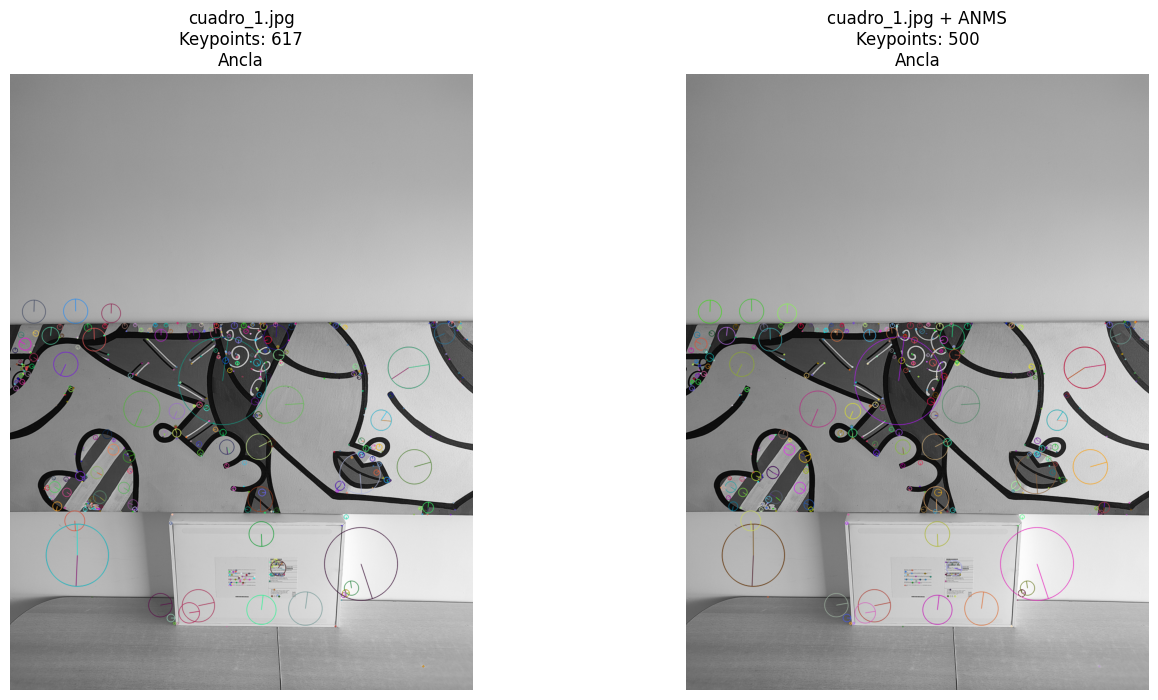

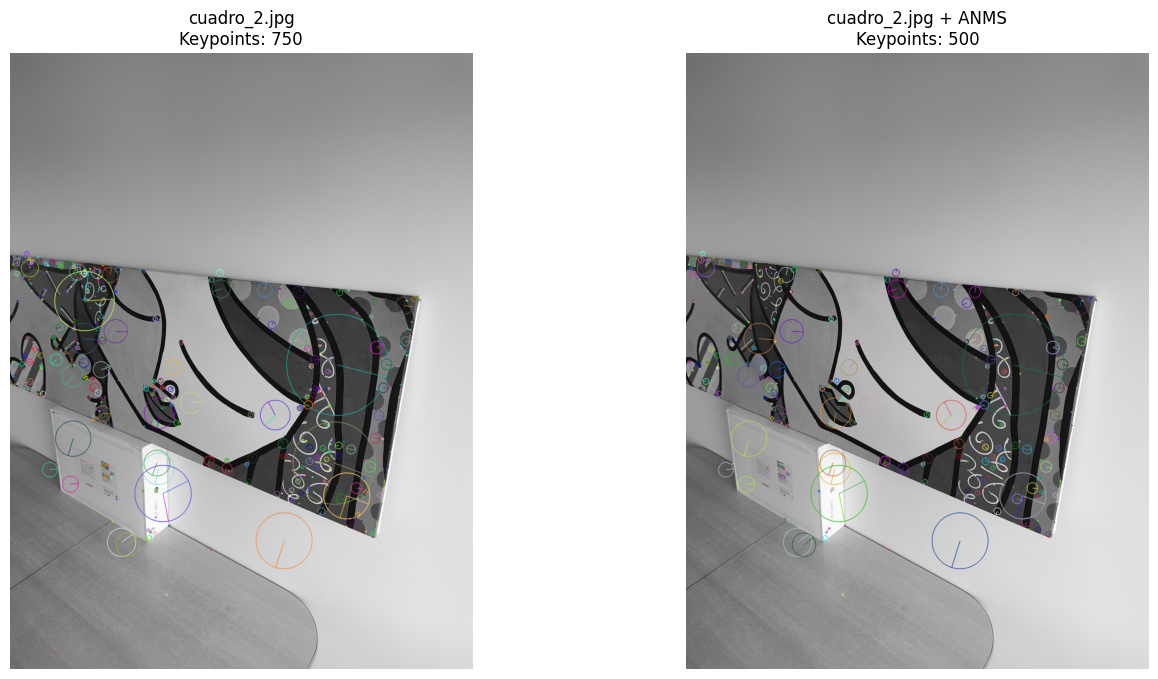

In [19]:
cuadro_data = {
    "imgs": CUADRO,
    "imgs_rgb": imgs_cuadro_rgb,
    "imgs_gray": imgs_cuadro_gray,
    "kps": kps_cuadro,
    "descs": descs_cuadro,
    "andor_idx": ANCHOR_IDX
}

# Adaptative Non-Maximal Suppression (ANMS)
kps_cuadro_anms, descs_cuadro_anms = [], []
for idx, (kps, descs) in enumerate(zip(kps_cuadro, descs_cuadro)):
    kps_anms, descs_anms = anms_select(kps, descs, 500)
    kps_cuadro_anms.append(kps_anms)
    descs_cuadro_anms.append(descs_anms)
    print(f"{CUADRO[idx]}: {len(kps)} keypoints -> {len(kps_anms)} después de ANMS")

# Visualización de keypoints antes vs. después de ANMS
for idx, (img_cuadro_gray, kps, kps_anms) in enumerate(zip(imgs_cuadro_gray, kps_cuadro, kps_cuadro_anms)):
    visualize_comparison(CUADRO, idx, img_cuadro_gray, kps, kps_anms, ANCHOR_IDX)

### (3)

=== Política A: SOLO Lowe ratio ===
cuadro_1.jpg ↔ cuadro_0.jpg: solo ratio=135


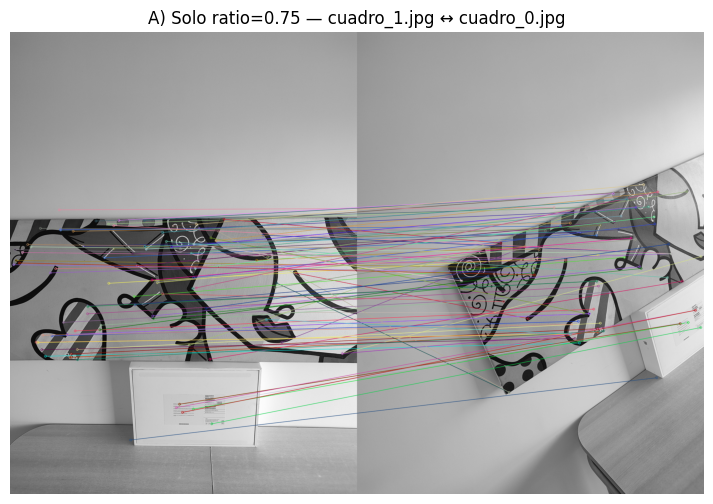

cuadro_1.jpg ↔ cuadro_0.jpg: ratio+cross=81 (vs solo ratio=135)


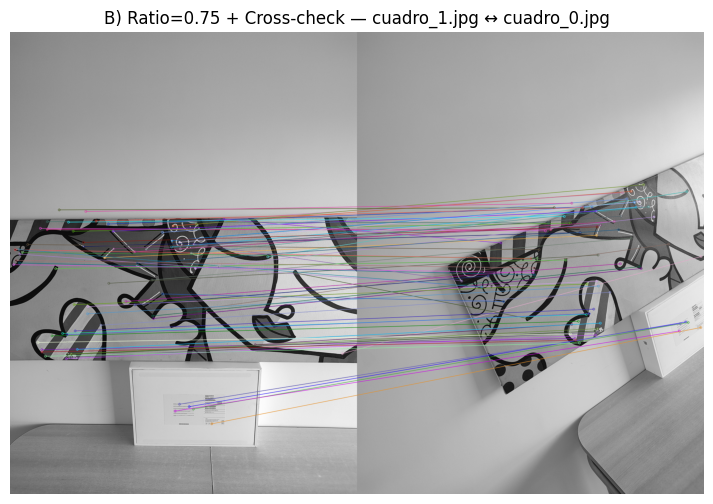

cuadro_1.jpg ↔ cuadro_2.jpg: solo ratio=71


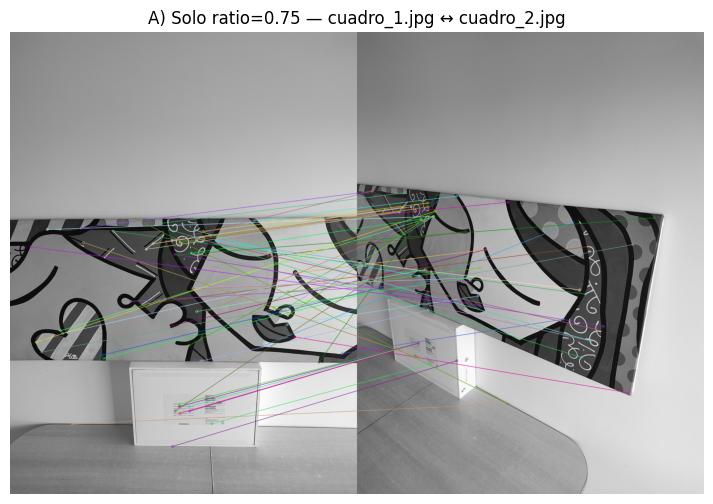

cuadro_1.jpg ↔ cuadro_2.jpg: ratio+cross=32 (vs solo ratio=71)


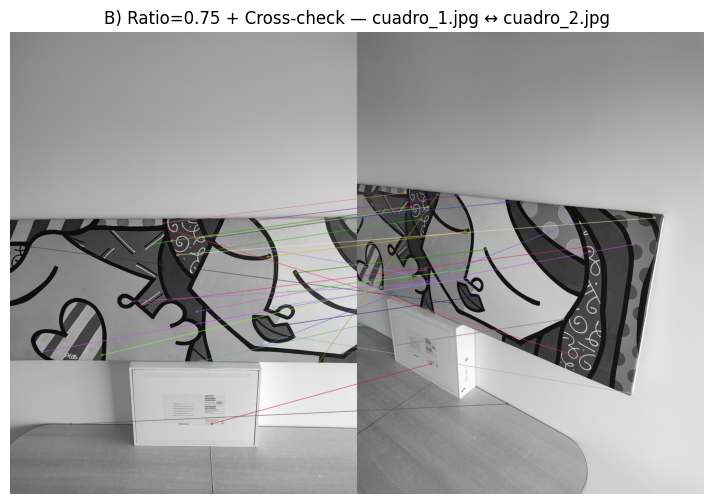

Listo: matches_cuadro (solo ratio) y matches_cuadro_alt (ratio+cross) listos para comparar.


In [23]:
# Elegir descriptores (ANMS si existen; si no, crudos)
kps_list  = kps_cuadro_anms  if 'kps_cuadro_anms'  in globals() and len(kps_cuadro_anms)==len(kps_cuadro) else kps_cuadro
desc_list = descs_cuadro_anms if 'descs_cuadro_anms' in globals() and len(descs_cuadro_anms)==len(descs_cuadro) else descs_cuadro

# Pares contra la ancla 
pairs = []
if ANCHOR_IDX - 1 >= 0:
    pairs.append((ANCHOR_IDX, ANCHOR_IDX - 1))
if ANCHOR_IDX + 1 < len(kps_list):
    pairs.append((ANCHOR_IDX, ANCHOR_IDX + 1))

# Parámetros
METHOD   = "bf"     
RATIO    = 0.75
USE_LOWE = True

# Diccionarios de resultados
matches_cuadro     = {}  # política principal (solo ratio)
matches_cuadro_alt = {}  # política alternativa (ratio + cross-check)

print("=== Política A: SOLO Lowe ratio ===")
for iA, iB in pairs:
    descA, descB = desc_list[iA], desc_list[iB]
    kpsA,  kpsB  = kps_list[iA],  kps_list[iB]

    if descA is None or descB is None or len(descA) == 0 or len(descB) == 0:
        print(f"Saltando {CUADRO[iA]} ↔ {CUADRO[iB]}: sin descriptores.")
        continue

    # --- Política A: solo Lowe ratio ---
    matches, dbg = match_descriptors(
        descA, descB,
        method=METHOD,
        use_lowe=USE_LOWE,
        ratio=RATIO,
        do_crosscheck=False
    )
    ptsA, ptsB = extract_matched_points(kpsA, kpsB, matches)
    key = f"{CUADRO[iA]} ↔ {CUADRO[iB]}"
    matches_cuadro[key] = {"iA": iA, "iB": iB, "matches": matches,
                           "ptsA": ptsA, "ptsB": ptsB,
                           "kpsA": kpsA, "kpsB": kpsB, "debug": dbg}
    print(f"{key}: solo ratio={len(matches)}")
    draw_matches_gray(imgs_cuadro_gray[iA], imgs_cuadro_gray[iB],
                      kpsA, kpsB, matches, max_draw=100,
                      title=f"A) Solo ratio={RATIO} — {key}")

    # --- Política B: Lowe ratio + cross-check ---
    matches_xc, dbg_xc = match_descriptors(
        descA, descB,
        method=METHOD,
        use_lowe=USE_LOWE,
        ratio=RATIO,
        do_crosscheck=True
    )
    ptsA_xc, ptsB_xc = extract_matched_points(kpsA, kpsB, matches_xc)
    matches_cuadro_alt[key] = {"iA": iA, "iB": iB, "matches": matches_xc,
                               "ptsA": ptsA_xc, "ptsB": ptsB_xc,
                               "kpsA": kpsA, "kpsB": kpsB, "debug": dbg_xc}
    print(f"{key}: ratio+cross={len(matches_xc)} (vs solo ratio={len(matches)})")
    draw_matches_gray(imgs_cuadro_gray[iA], imgs_cuadro_gray[iB],
                      kpsA, kpsB, matches_xc, max_draw=100,
                      title=f"B) Ratio={RATIO} + Cross-check — {key}")

# Guardar parámetros
matches_cuadro_params = {"method": METHOD, "ratio": RATIO, "lowe": USE_LOWE}

print("Listo: matches_cuadro (solo ratio) y matches_cuadro_alt (ratio+cross) listos para comparar.")
